# New York City Yellow Taxi Data Analysis 

Let's look at the 2016 Yellow Taxi trip data

![Yellow Cab](./img/ny_yellow_cab.jpg)


In [1]:
import numpy as np
import pandas as pd
import math

import cudf
import cugraph

import os
from collections import OrderedDict
import argparse
import datetime
import time

import nyctaxi_data

## Download the data

In [2]:
top_dir = "./"
data_dir = "./nyctaxi"

In [3]:
# Download Taxi data

if os.path.exists(data_dir) == False:
    print("downloading data")
    nyctaxi_data.download_nyctaxi_data(["2016"], top_dir)
    

# Let's load the data

In [4]:
# Specifying the column names and formats speeds up the data reading
columns_dtypes = OrderedDict(
    [
        ('vendor_id', 'int32'),
        ('pickup_datetime', 'date'),
        ('dropoff_datetime', 'date'),
        ('passenger_count', 'int32'),
        ('trip_distance', 'int32'),
        ('pickup_longitude', 'float64'),
        ('pickup_latitude', 'float64'),
        ('rate_code', 'int32'),
        ('store_and_fwd_flag', 'int32'),
        ('dropoff_longitude', 'float64'),
        ('dropoff_latitude', 'float64'),
        ('payment_type', 'int32'),
        ('fare_amount', 'float64'),
        ('extra', 'float64'),
        ('mta_tax', 'float64'),
        ('tip_amount', 'float64'),
        ('tolls_amount', 'float64'),
        ('surcharge', 'float64'),
        ('total_amount', 'float64')
    ]
)

In [5]:
# We do not want to use every column, specify the ones we want
use_col  = [
    'pickup_datetime',
    'dropoff_datetime',
    'passenger_count', 
    'trip_distance',
    'pickup_longitude',
    'pickup_latitude',     
    'rate_code',
    'dropoff_longitude',
    'dropoff_latitude',    
    'fare_amount',
    'extra',
    'tip_amount',
    'total_amount'
]

In [6]:
# limiting to only four files - this can be changed based on how much memory is available in the GPU
files = ['yellow_tripdata_2016-01.csv', 'yellow_tripdata_2016-02.csv', 'yellow_tripdata_2016-03.csv', 'yellow_tripdata_2016-04.csv']

data = []

start_t = time.time()

for f in files:
    data.append(
        cudf.read_csv(
            os.path.join(data_dir, f'2016/{f}')
            , names=list(columns_dtypes.keys())
            , dtype=list(columns_dtypes.values())
            , skip_rows=1
            , usecols=use_col
        )
    )
    
taxi_df = cudf.concat(data)

end_t = time.time()

del data

In [7]:
print("loaded " + str(len(taxi_df)) + " records in " + str(end_t - start_t) + " seconds")

loaded 46434201 records in 4.0431249141693115 seconds


## Clean up
The data contains a lot of bad records.  Let's try and clean it up some

__Homework Assignment__:  
* How much bad data is being removed?
* Could we infer anything from looking at the removed data?

In [8]:
# filter out records with missing or outlier values
query_frags = ("(fare_amount > 0 and fare_amount < 500) " +
        "and (passenger_count > 0 and passenger_count < 6) " +
        "and (pickup_longitude > -75 and pickup_longitude < -73) " +
        "and (dropoff_longitude > -75 and dropoff_longitude < -73) " +
        "and (pickup_latitude > 40 and pickup_latitude < 42) " +
        "and (dropoff_latitude > 40 and dropoff_latitude < 42)" +
        "and (pickup_latitude != dropoff_latitude) " +
        "and (pickup_longitude != dropoff_longitude)"
    )

taxi_df = taxi_df.query(query_frags)

## Add some new features

In [9]:
def day_of_the_week_kernel(day, month, year, day_of_week):
    for i, (d_1, m_1, y_1) in enumerate(zip(day, month, year)):
        if month[i] < 3:
            shift = month[i]
        else:
            shift = 0
        Y = year[i] - (month[i] < 3)
        y = Y - 2000
        c = 20
        d = day[i]
        m = month[i] + shift + 1
        day_of_week[i] = (d + math.floor(m * 2.6) + y + (y // 4) + (c // 4) - 2 * c) % 7

In [10]:
def add_features(df):
    df['hour'] = df['pickup_datetime'].dt.hour
    df['year'] = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day'] = df['pickup_datetime'].dt.day
    df['diff'] = df['dropoff_datetime'].astype('int64') - df['pickup_datetime'].astype('int64')
    
    df = df.apply_rows(
        day_of_the_week_kernel
        , incols = ['day', 'month', 'year']
        , outcols = {'day_of_week': np.int32}
        , kwargs = {}
    )

    df = df.drop('pickup_datetime')
    df = df.drop('dropoff_datetime')
        
    return df

In [11]:
%%time
taxi_df = add_features(taxi_df)

CPU times: user 258 ms, sys: 184 ms, total: 443 ms
Wall time: 453 ms


---
# Graph 
We like vertex ID to be nice integers but what we have are lat-long pairs.  There are two way that we can address that issue

### Create vertices and edges by hand

In [12]:
# create node ID from unique lat-long combinatiuons
nodes = [
      taxi_df[['pickup_longitude', 'pickup_latitude']].drop_duplicates().rename({'pickup_longitude': 'long', 'pickup_latitude': 'lat'})
    , taxi_df[['dropoff_longitude', 'dropoff_latitude']].drop_duplicates().rename({'dropoff_longitude': 'long', 'dropoff_latitude': 'lat'})
]

nodes = cudf.concat(nodes).drop_duplicates().reset_index(drop=True).reset_index().rename({'index': 'id'})
nodes.head(5)

,id,long,lat
0,0,-74.997330,41.879631
1,1,-74.988434,40.049549
2,2,-74.973709,40.591049
3,3,-74.962234,40.598579
4,4,-74.960526,41.518776


In [13]:
print('Total number of geo points in the dataset: {0:,}'.format(len(nodes)))

Total number of geo points in the dataset: 39,845,258


In [14]:
edges = (
    taxi_df[['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'trip_distance']]
    .drop_duplicates()
    .rename({'pickup_longitude': 'long', 'pickup_latitude': 'lat'})
    .merge(nodes, on=['lat', 'long'])
    .rename({'long': 'pickup_longitude', 'lat': 'pickup_latitude', 'id': 'pickup_id', 'dropoff_longitude': 'long', 'dropoff_latitude': 'lat'})
    .merge(nodes, on=['lat', 'long'])
    .rename({'long': 'dropoff_longitude', 'lat': 'dropoff_latitude', 'id': 'dropoff_id'})
)[['pickup_id', 'dropoff_id', 'trip_distance']]

edges.head().to_pandas()

,pickup_id,dropoff_id,trip_distance
0,176610,275688,0
1,176611,728793,0
2,176611,12030925,4
3,176611,20128565,6
4,176611,28835038,8


In [15]:
sources      = edges['pickup_id'].astype('int32')
destinations = edges['dropoff_id'].astype('int32')
distances    = edges['trip_distance'].astype('int32')

g = cugraph.Graph()
g.add_edge_list(sources, destinations, None)

/home/brad/anaconda3/envs/cugraph_dev/lib/python3.7/site-packages/cugraph-0.15.0a0+203.g45b02a24.dirty-py3.7-linux-x86_64.egg/cugraph/structure/graph.py:193: UserWarning: add_edge_list will be deprecated in next release. Use from_cudf_edgelist instead
  Use from_cudf_edgelist instead')


# Graph distribution of degrees

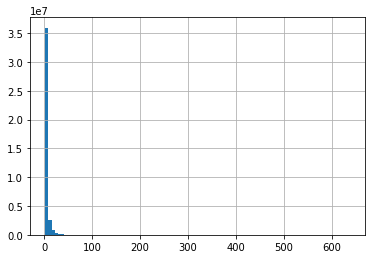

In [17]:
%matplotlib inline
g.degree().to_pandas()['degree'].hist(bins=100)

# Pagerank

In [18]:
page = cugraph.pagerank(g, alpha=.85, max_iter=1000, tol=1.0e-05)

In [19]:
page.sort_values(by='pagerank', ascending=False).head(5).to_pandas()


,vertex,pagerank
20199468,39755074,0.000003
20248118,39755084,0.000003
35307018,38799833,0.000003
20223793,39755079,0.000002
17572368,39754534,0.000002


# Jaccard similarity

In [20]:
df = cugraph.jaccard(g)
df.sort_values(by='jaccard_coeff', ascending=False).head()

,source,destination,jaccard_coeff
8768479,36893082,36895808,0.333333
38079202,36895808,36893082,0.333333
43819238,4080,4081,0.333333
43829744,4081,4080,0.333333
43808759,4079,4080,0.250000


## Now the easy way

In [39]:
taxi_df.reset_index().head(5)

,index,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,extra,tip_amount,total_amount,hour,year,month,day,diff,day_of_week
0,1,2,1,-73.990372,40.734695,1,-73.981842,40.732407,7.5,0.5,0.0,8.8,0,2016,1,1,0,5
1,2,5,4,-73.980782,40.729912,1,-73.944473,40.716679,18.0,0.5,0.0,19.3,0,2016,1,1,0,5
2,3,1,10,-73.984550,40.679565,1,-73.950272,40.788925,33.0,0.5,0.0,34.3,0,2016,1,1,0,5
3,4,1,4,-73.993469,40.718990,1,-73.962242,40.657333,16.5,0.0,0.0,17.3,0,2016,1,1,0,5
4,5,3,1,-73.960625,40.781330,1,-73.977264,40.758514,8.0,0.0,0.0,8.8,0,2016,1,1,0,5


In [37]:
taxi_df['src'], taxi_df['dst'], _ = cugraph.renumber_from_cudf(taxi_df, source_cols_names=['pickup_longitude', 'pickup_latitude'], dest_cols_names=['dropoff_longitude', 'dropoff_latitude'])

ValueError: Cannot align indices with non-unique values

In [32]:
src.head(5)

0    10690534
1    35324016
2    22181424
3    22080659
4    18905410
Name: id, dtype: int32

In [33]:
dst.head(5)

0    17918475
1     9489059
2     3608681
3    21482313
4    35913441
Name: id, dtype: int32

In [29]:
g2 = cugraph.Graph()
g2.from_cudf_edgelist(taxi_df, 
                      source=['pickup_longitude', 'pickup_latitude'], 
                      destination=['dropoff_longitude', 'dropoff_latitude'], 
                      edge_attr='trip_distance',
                      renumber=True)

ValueError: Cannot align indices with non-unique values

In [28]:
page = cugraph.pagerank(g2, alpha=.85, max_iter=1000, tol=1.0e-05)
page.sort_values(by='pagerank', ascending=False).head(5).to_pandas()

passenger_count        int32
trip_distance          int32
pickup_longitude     float64
pickup_latitude      float64
rate_code              int32
dropoff_longitude    float64
dropoff_latitude     float64
fare_amount          float64
extra                float64
tip_amount           float64
total_amount         float64
hour                   int16
year                   int16
month                  int16
day                    int16
diff                   int64
day_of_week            int32
dtype: object

In [24]:
%matplotlib inline
g2.degree().to_pandas()['degree'].hist(bins=100)

TypeError: unhashable type: 'Series'

# Visualize the trips

## Heatmap of dropoff points

In [ ]:
import math

def degrees_to_2d(lon_in, lat_in, x, y):
    for i, (lon, lat) in enumerate(zip(lon_in, lat_in)):
        x[i] = lon * 20037508.34 / 180
        temp = math.log(math.tan((90 + lat) * math.pi / 360)) / (math.pi / 180)
        y[i] = temp * 20037508.34 / 180
        
taxi_2d = taxi_df[['dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour', 'day_of_week', 'month']]
taxi_2d = taxi_2d.apply_rows(
      degrees_to_2d
    , incols = {'dropoff_longitude': 'lon_in', 'dropoff_latitude': 'lat_in'}
    , outcols = {'x': np.float64, 'y': np.float64}
    , kwargs = {}
)

taxi_2d['passenger_count'] = taxi_2d['passenger_count'].astype('float64')

In [ ]:
# Overloading Datashader functions
import cudatashader as ds
from cudatashader import transfer_functions as tf
from cudatashader.colors import Hot

# t0 = time.time() # Save start time
cvs = ds.Canvas(plot_width=750, plot_height=625, x_range=(-8239910.23,-8229529.24), y_range=(4968481.34,4983152.92)) # Create canvas
agg = cvs.points(taxi_2d, 'x', 'y', ds.count('passenger_count')) # Perform aggregation
img = tf.shade(agg, cmap=Hot, how='eq_hist') # Produce image from aggregation

In [ ]:
img

## Interactive visualization of millions of point

In [ ]:
import cuXfilter
from cuXfilter import charts

In [ ]:
cux_df = cuXfilter.DataFrame.from_dataframe(taxi_2d)

In [ ]:
label_map = {0: 'Sunday', 1: 'Monday',    2: 'Tuesday',    3: 'Wednesday',   4: 'Thursday',    5: 'Friday',    6: 'Saturday',    9: 'Unknown'}
red_blue_palette = [ (49,130,189), (107,174,214), (123, 142, 216), (226,103,152), (255,0,104) , (50,50,50) ]

chart1 = charts.cudatashader.scatter_geo(
      x='x'
    , y='y'
    , aggregate_fn='count'
    , x_range=(-8239910.23,-8229529.24), y_range=(4968481.34,4983152.92)
    , color_palette=red_blue_palette
)

chart2 = charts.panel_widgets.multi_select('month')
chart3 = charts.bokeh.bar('passenger_count', data_points=5)
chart4 = charts.bokeh.bar('day_of_week', x_label_map=label_map)

In [ ]:
d = cux_df.dashboard([chart1, chart2, chart3, chart4], layout=cuXfilter.layouts.feature_and_double_base, theme=cuXfilter.themes.light, title= 'NYC TAXI DATASET')

In [ ]:
d.show('opportunity.local:8778')